In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import (
    RobertaTokenizerFast,
    RobertaModel,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW   
from transformers import DebertaV2Model, DebertaV2TokenizerFast

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
import torch.backends.cudnn as cudnn
from sklearn.metrics import f1_score
import torch.nn.functional as F
import numpy as np
from torch.cuda.amp import autocast, GradScaler

cudnn.benchmark = True


2025-04-27 12:19:26.593654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745756366.832448      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745756366.903360      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df = pd.read_csv('/kaggle/input/eng-csv/eng.csv')
df.head()


X_cols = ['text']
Y_cols = ['anger', 'fear', 'joy', 'sadness', 'surprise']
y = df[Y_cols].values
X = list(df[X_cols].values.flatten())

labels = torch.tensor(y, dtype=torch.float32)
print(labels.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X, labels,
    test_size=0.1,
    random_state=42
)

torch.Size([2768, 5])


In [6]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
class MakeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts, self.labels = texts, labels
        self.tokenizer, self.max_len = tokenizer, max_len

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": torch.FloatTensor(self.labels[idx])
        }
train_ds = MakeDataset(X_train, y_train, tokenizer)
val_ds   = MakeDataset(X_val,   y_val,   tokenizer)
train_loader = DataLoader(train_ds, batch_size=32, sampler=RandomSampler(train_ds), pin_memory=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=64, pin_memory=True, num_workers=2)

base_model = AutoModel.from_pretrained("microsoft/deberta-v3-base")
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION
)
base_model = get_peft_model(base_model, peft_config)

for name, param in base_model.named_parameters():
    param.requires_grad = True

class Net(nn.Module):
    def __init__(self, base, hidden_dim=384, num_labels=5):
        super().__init__()
        self.base = base
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(base.config.hidden_size, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.out = nn.Linear(hidden_dim // 2, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        x = self.dropout(F.relu(self.bn1(self.fc1(pooled))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        return self.out(x)
model = Net(base_model).to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [7]:
label_counts = np.sum(np.array(y_train), axis=0)
pos_weight_vals = (len(y_train) - label_counts) / label_counts
pos_weight = torch.tensor(pos_weight_vals, dtype=torch.float32).to(model.base.device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
total_steps = len(train_loader) * 10
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=100, num_training_steps=total_steps
)
scaler = GradScaler()

/tmp/ipykernel_31/4043554685.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [8]:
best_val_f1 = 0
best_val_loss = float("inf")
thresh = 0.5
for epoch in range(20):
    model.train()
    running_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(model.base.device, non_blocking=True)
        masks     = batch["attention_mask"].to(model.base.device, non_blocking=True)
        labels    = batch["labels"].to(model.base.device, non_blocking=True)
        with autocast():
            logits = model(input_ids=input_ids, attention_mask=masks)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()
    avg_train = running_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [] , []
    with torch.no_grad():
        for batch in val_loader:
            ids = batch["input_ids"].to(model.base.device, non_blocking=True)
            masks = batch["attention_mask"].to(model.base.device, non_blocking=True)
            labs = batch["labels"].to(model.base.device, non_blocking=True)
            logits = model(input_ids=ids, attention_mask=masks)
            val_loss += criterion(logits, labs).item()
            probs = torch.sigmoid(logits).cpu()
            all_preds.append((probs > thresh).int())
            all_labels.append(labs.cpu().int())
    avg_val = val_loss / len(val_loader)

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    if macro_f1 > best_val_f1:
        best_val_f1 = macro_f1
        model.base.save_pretrained("best_deberta_lora")
        torch.save(model.state_dict(), "best_model_state.pt")
        tokenizer.save_pretrained("best_deberta_lora")

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"Epoch {epoch+1} — train loss: {avg_train:.4f} — val loss: {avg_val:.4f} — val macro-F1: {macro_f1:.4f}")
    # print(classification_report(y_true, y_pred, target_names=["anger", "fear", "joy", "sadness", "surprise"]))

print("Best model statistics:")
model.load_state_dict(torch.load("best_model_state.pt"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        ids = batch["input_ids"].to(model.base.device)
        masks = batch["attention_mask"].to(model.base.device)
        labs = batch["labels"].to(model.base.device)
        logits = model(ids, masks)
        probs = torch.sigmoid(logits).cpu()
        all_preds.append((probs > thresh).int())
        all_labels.append(labs.cpu().int())

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
final_macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("Final model — macro-F1:", round(final_macro_f1, 4))
if macro_f1 > best_val_f1:
    best_val_f1 = macro_f1
    model.base.save_pretrained("best_deberta_lora")
    torch.save(model.state_dict(), "best_model_state.pt")
    tokenizer.save_pretrained("best_deberta_lora")


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 — train loss: 0.9818 — val loss: 0.9220 — val macro-F1: 0.1318


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 — train loss: 0.8456 — val loss: 0.7486 — val macro-F1: 0.5667


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 — train loss: 0.6530 — val loss: 0.6504 — val macro-F1: 0.6462


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 — train loss: 0.5266 — val loss: 0.6230 — val macro-F1: 0.6699


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 — train loss: 0.4425 — val loss: 0.6687 — val macro-F1: 0.6551


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 — train loss: 0.3852 — val loss: 0.6104 — val macro-F1: 0.6993


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 — train loss: 0.3429 — val loss: 0.6183 — val macro-F1: 0.6988


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 — train loss: 0.3186 — val loss: 0.6300 — val macro-F1: 0.7024


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 — train loss: 0.3028 — val loss: 0.6120 — val macro-F1: 0.7072


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 — train loss: 0.2902 — val loss: 0.6159 — val macro-F1: 0.7080


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 — train loss: 0.2853 — val loss: 0.6143 — val macro-F1: 0.7077


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 — train loss: 0.2868 — val loss: 0.6135 — val macro-F1: 0.7080


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 — train loss: 0.2831 — val loss: 0.6154 — val macro-F1: 0.7104


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 — train loss: 0.2860 — val loss: 0.6155 — val macro-F1: 0.7083


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 — train loss: 0.2862 — val loss: 0.6127 — val macro-F1: 0.7104


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16 — train loss: 0.2871 — val loss: 0.6165 — val macro-F1: 0.7058


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 — train loss: 0.2886 — val loss: 0.6155 — val macro-F1: 0.7093


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 — train loss: 0.2918 — val loss: 0.6155 — val macro-F1: 0.7098


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19 — train loss: 0.2860 — val loss: 0.6166 — val macro-F1: 0.7067


/tmp/ipykernel_31/1698962579.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20 — train loss: 0.2865 — val loss: 0.6163 — val macro-F1: 0.7071
Best model statistics:


/tmp/ipykernel_31/1698962579.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_state.pt"))


Final model — macro-F1: 0.7104


In [9]:

model.load_state_dict(torch.load("best_model_state.pt"))

preds = torch.cat(all_preds)
labs  = torch.cat(all_labels)
print(classification_report(
    labs, preds,
    target_names=["anger","fear","joy","sadness","surprise"],
    zero_division=0
))

/tmp/ipykernel_31/3072557869.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_state.pt"))


              precision    recall  f1-score   support

       anger       0.62      0.59      0.61        34
        fear       0.85      0.84      0.84       168
         joy       0.59      0.81      0.68        48
     sadness       0.63      0.75      0.68        84
    surprise       0.71      0.76      0.73        83

   micro avg       0.72      0.78      0.75       417
   macro avg       0.68      0.75      0.71       417
weighted avg       0.73      0.78      0.75       417
 samples avg       0.67      0.73      0.67       417



In [14]:
device = 'cuda'
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader

X_cols = ['text']
Y_cols = ['anger', 'fear', 'joy', 'sadness', 'surprise']
y_t = df[Y_cols].values
X_t = list(df[X_cols].values.flatten())
labels = torch.tensor(y_t, dtype=torch.float32)

test_ds = MakeDataset(X_t, labels, tokenizer)
test_loader = DataLoader(test_ds, batch_size=32)

model.load_state_dict(torch.load("best_model_state.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(device)
        masks = batch["attention_mask"].to(device)
        labs = batch["labels"].to(device)
        logits = model(ids, masks)
        probs = torch.sigmoid(logits).cpu()
        preds = torch.stack([(probs[:, i] > 0.5).int() for i in range(probs.shape[1])], dim=1)
        all_preds.append(preds)
        all_labels.append(labs.cpu().int())

preds_tensor = torch.cat(all_preds)
labels_tensor = torch.cat(all_labels)

label_names = ["anger", "fear", "joy", "sadness", "surprise"]
print(classification_report(labels_tensor, preds_tensor, target_names=label_names, zero_division=0))

f1s = f1_score(labels_tensor, preds_tensor, average=None, zero_division=0)
for name, f1 in zip(label_names, f1s):
    print(f"{name:>8} F1: {f1:.4f}")

print(f"\nMacro F1: {f1_score(labels_tensor, preds_tensor, average='macro', zero_division=0):.4f}")
print(f"Micro F1: {f1_score(labels_tensor, preds_tensor, average='micro', zero_division=0):.4f}")


/tmp/ipykernel_31/2509213828.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_state.pt"))


              precision    recall  f1-score   support

       anger       0.96      0.96      0.96       333
        fear       0.90      0.89      0.89      1611
         joy       0.95      0.98      0.96       674
     sadness       0.91      0.97      0.94       878
    surprise       0.95      0.97      0.96       839

   micro avg       0.93      0.94      0.93      4335
   macro avg       0.93      0.95      0.94      4335
weighted avg       0.92      0.94      0.93      4335
 samples avg       0.86      0.87      0.85      4335

   anger F1: 0.9565
    fear F1: 0.8936
     joy F1: 0.9642
 sadness F1: 0.9427
surprise F1: 0.9611

Macro F1: 0.9436
Micro F1: 0.9327


In [ ]:
import torch
import numpy as np
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

all_probs, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        ids = batch["input_ids"].to(model.base.device)
        masks = batch["attention_mask"].to(model.base.device)
        labs = batch["labels"].to(model.base.device)
        logits = model(ids, masks)
        probs = torch.sigmoid(logits).cpu()
        all_probs.append(probs)
        all_labels.append(labs.cpu())

probs = torch.cat(all_probs)
labels = torch.cat(all_labels)

optimal_thresholds = []
for i in range(probs.shape[1]):
    best_thresh, best_f1 = 0.5, 0
    for t in np.arange(0.1, 0.9, 0.01):
        pred = (probs[:, i] > t).int()
        f1 = f1_score(labels[:, i], pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    optimal_thresholds.append(best_thresh)

print("Optimized per-label thresholds:", optimal_thresholds)
print("Best F1 score:", best_f1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Optimized per-label thresholds: [0.3799999999999999, 0.4999999999999998, 0.5999999999999998, 0.7199999999999996, 0.3599999999999999]
Best F1 score: 0.7597765363128491


In [38]:
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader

df1 = pd.read_csv('/kaggle/input/engl-test/eng_test.csv')
X_cols = ['text']
Y_cols = ['anger', 'fear', 'joy', 'sadness', 'surprise']
y_t = df1[Y_cols].values
X_t = list(df1[X_cols].values.flatten())
labels = torch.tensor(y_t, dtype=torch.float32)

test_ds = MakeDataset(X_t, labels, tokenizer)
test_loader = DataLoader(test_ds, batch_size=32)

model.load_state_dict(torch.load("best_model_state.pt"))
model.eval()

thresholds = optimal_thresholds

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(device)
        masks = batch["attention_mask"].to(device)
        labs = batch["labels"].to(device)
        logits = model(ids, masks)
        probs = torch.sigmoid(logits).cpu()
        preds = torch.stack([(probs[:, i] > 0.5).int() for i in range(probs.shape[1])], dim=1)
        all_preds.append(preds)
        all_labels.append(labs.cpu().int())

preds_tensor = torch.cat(all_preds)
labels_tensor = torch.cat(all_labels)

label_names = ["anger", "fear", "joy", "sadness", "surprise"]
print(classification_report(labels_tensor, preds_tensor, target_names=label_names, zero_division=0))

f1s = f1_score(labels_tensor, preds_tensor, average=None, zero_division=0)
for name, f1 in zip(label_names, f1s):
    print(f"{name:>8} F1: {f1:.4f}")

print(f"\nMacro F1: {f1_score(labels_tensor, preds_tensor, average='macro', zero_division=0):.4f}")
print(f"Micro F1: {f1_score(labels_tensor, preds_tensor, average='micro', zero_division=0):.4f}")

/tmp/ipykernel_31/1470529662.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_state.pt"))


              precision    recall  f1-score   support

       anger       0.61      0.61      0.61       322
        fear       0.81      0.81      0.81      1544
         joy       0.71      0.77      0.74       670
     sadness       0.69      0.79      0.74       881
    surprise       0.66      0.79      0.72       799

   micro avg       0.72      0.78      0.75      4216
   macro avg       0.69      0.76      0.72      4216
weighted avg       0.72      0.78      0.75      4216
 samples avg       0.68      0.71      0.67      4216

   anger F1: 0.6102
    fear F1: 0.8091
     joy F1: 0.7357
 sadness F1: 0.7388
surprise F1: 0.7232

Macro F1: 0.7234
Micro F1: 0.7504


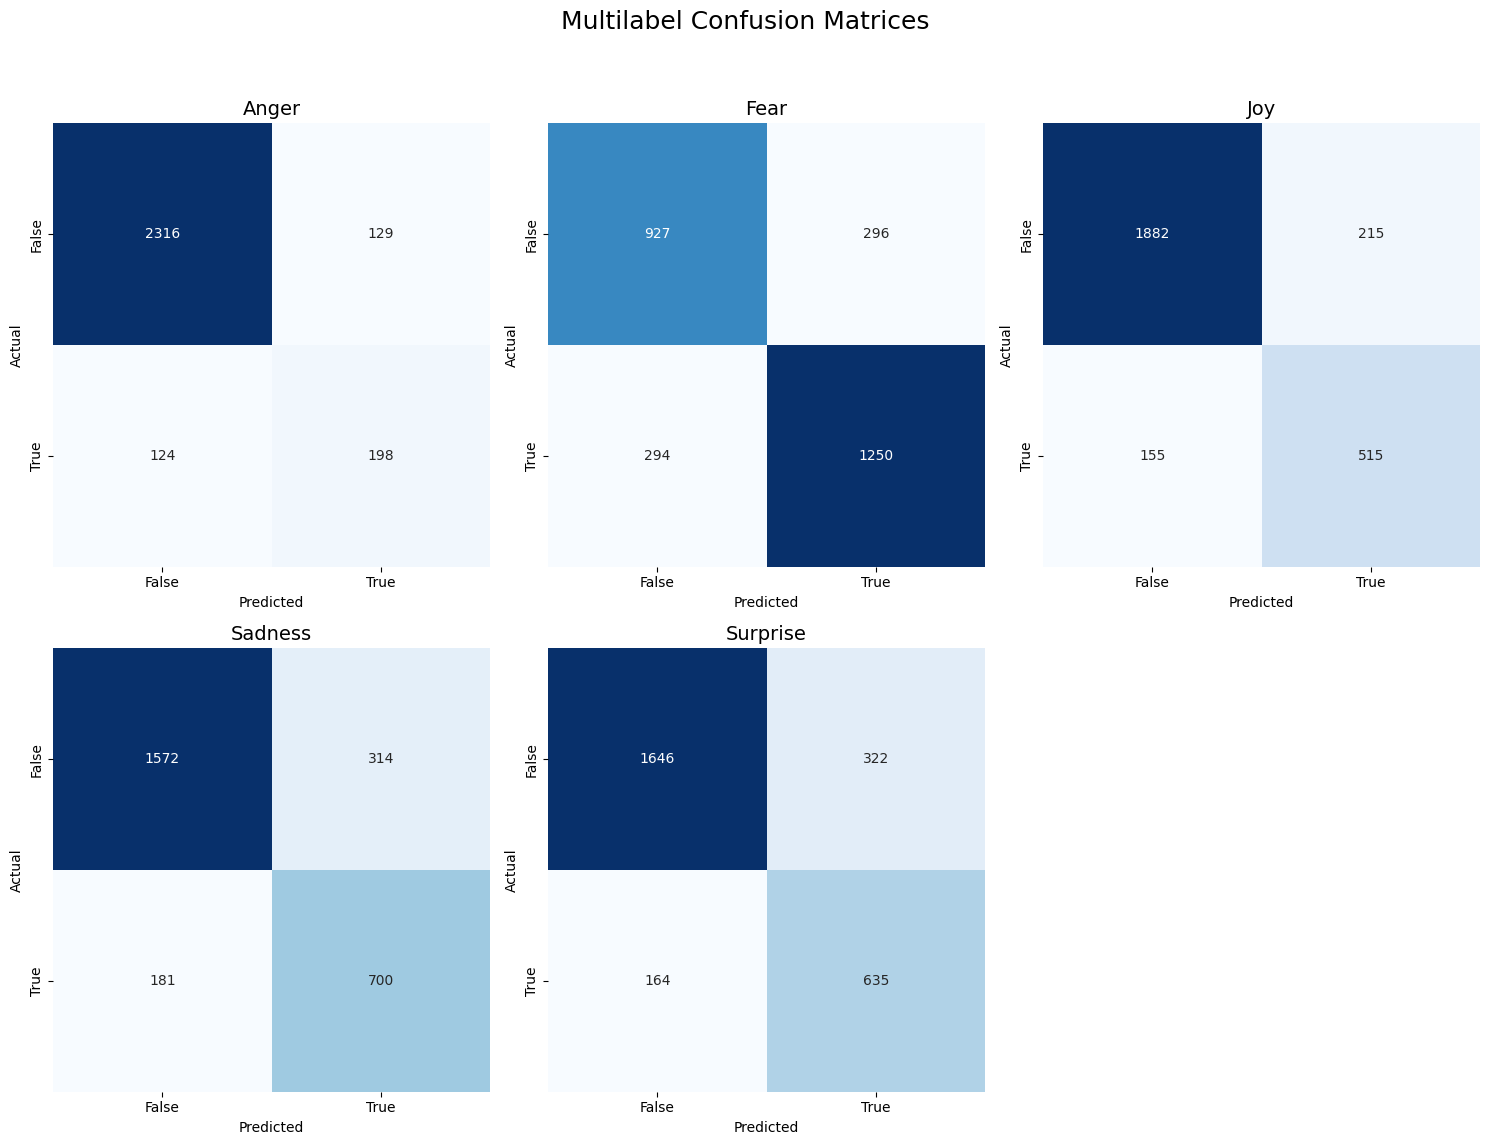

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = multilabel_confusion_matrix(labels_tensor, preds_tensor)

fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Multilabel Confusion Matrices', fontsize=18)

emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]

for idx, ax in enumerate(axes.flat):
    if idx < len(emotion_labels):
        sns.heatmap(conf_matrix[idx], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(emotion_labels[idx], fontsize=14)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_xticklabels(['False', 'True'])
        ax.set_yticklabels(['False', 'True'])
    else:
        ax.axis('off')  

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from peft import PeftModel, PeftConfig
from bertviz import model_view

def visualize_lora_attention(
    sentence: str,
    model_path: str = "best_deberta_lora",
    weights_path: str = "best_model_state.pt",
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
):

    peft_config = PeftConfig.from_pretrained(model_path)

    base_model = AutoModel.from_pretrained(peft_config.base_model_name_or_path, output_hidden_states=True)
    base_model = PeftModel.from_pretrained(base_model, model_path)

    class Net(nn.Module):
        def __init__(self, base, hidden_dim=384, num_labels=5):
            super().__init__()
            self.base = base
            self.dropout = nn.Dropout(0.3)
            self.fc1 = nn.Linear(base.config.hidden_size, hidden_dim)
            self.bn1 = nn.BatchNorm1d(hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
            self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
            self.out = nn.Linear(hidden_dim // 2, num_labels)

        def forward(self, input_ids, attention_mask):
            outputs = self.base(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_attentions=True 
            )
            pooled = torch.stack(outputs.hidden_states[-4:]).mean(dim=0)[:, 0]
            x = self.dropout(F.relu(self.bn1(self.fc1(pooled))))
            x = self.dropout(F.relu(self.bn2(self.fc2(x))))
            return self.out(x), outputs.attentions, input_ids

    model = Net(base_model).to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True).to(device)

    with torch.no_grad():
        logits, attentions, input_ids = model(inputs["input_ids"], inputs["attention_mask"])
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    emotions = ["anger", "fear", "joy", "sadness", "surprise"]
    for emotion, prob in zip(emotions, probs):
        print(f"{emotion}: {prob:.4f}")

    if attentions:
        model_view(attentions, tokens)
    else:
        print("No attention weights available for visualization.")


In [ ]:
visualize_lora_attention("I start getting a little drowsy and take a sip")

/tmp/ipykernel_31/869954307.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))
Asking to truncate to m

anger: 0.4858
fear: 0.3893
joy: 0.4733
sadness: 0.4045
surprise: 0.3923


<IPython.core.display.Javascript object>

In [37]:
visualize_lora_attention("I am not smart, and that is depressing")

/tmp/ipykernel_31/869954307.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))
Asking to truncate to m

anger: 0.5802
fear: 0.4631
joy: 0.4167
sadness: 0.6428
surprise: 0.4395


<IPython.core.display.Javascript object>

In [27]:
visualize_lora_attention("I finished studying and doing all my homework!")

/tmp/ipykernel_31/869954307.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))
Asking to truncate to m

anger: 0.4756
fear: 0.3606
joy: 0.6028
sadness: 0.3624
surprise: 0.3885


<IPython.core.display.Javascript object>

In [30]:
visualize_lora_attention("I thought today would be fun, but it turned out disappointing.")

/tmp/ipykernel_31/869954307.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))
Asking to truncate to m

anger: 0.5837
fear: 0.4073
joy: 0.4934
sadness: 0.6329
surprise: 0.5021


<IPython.core.display.Javascript object>

In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch.nn.functional as F

class_names = ["anger", "fear", "joy", "sadness", "surprise"]

def predict_proba(texts, batch_size=8):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
            logits = model(inputs["input_ids"], inputs["attention_mask"])  
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu())

    return torch.cat(all_probs, dim=0).numpy()

explainer = LimeTextExplainer(class_names=class_names)

text = "I feel overwhelmed and exhausted."

exp = explainer.explain_instance(
    text_instance=text,
    classifier_fn=predict_proba,
    num_features=10,
    labels=list(range(len(class_names)))  
)

exp.show_in_notebook(text=True, labels=[2])

In [ ]:
text = "I finished studying and doing all my homework!"

exp = explainer.explain_instance(
    text_instance=text,
    classifier_fn=predict_proba,
    num_features=10,
    labels=list(range(len(class_names)))  
)

exp.show_in_notebook(text=True, labels=[2])

In [ ]:
text = "I thought today would be fun, but it turned out disappointing."

exp = explainer.explain_instance(
    text_instance=text,
    classifier_fn=predict_proba,
    num_features=10,
    labels=list(range(len(class_names)))  
)

exp.show_in_notebook(text=True, labels=[3])